In [58]:
#initializing node structure
import chess
import chess.pgn
import chess.engine
import random
import time
import numpy as np
from math import log,sqrt,e,inf
from IPython.display import display, HTML, clear_output
engine = chess.engine.SimpleEngine.popen_uci(r'stockfish-11-win/Windows/stockfish_20011801_x64.exe')

#engine = chess.engine.SimpleEngine.popen_uci("stockfish")


class node:
    def __init__(self,*board):
        if(len(board)>0):
            self.state = board
        else:
            self.state = chess.Board()
        self.action = ''
        self.children = set()
        self.parent = None
        self.N = 0
        self.n = 0
        self.v = 0

In [59]:
#method for ucb and AI rollout
def ucb1(curr_node):
    ans = curr_node.v+2*(sqrt(log(curr_node.N+e+(10**-6))/(curr_node.n+(10**-10))))
    return ans

def rollout(board,curr_node):
    global engine
    if(curr_node.state.is_game_over()):
        board1 = curr_node.state
        if(board1.result()=='1-0'):
            return (1,curr_node)
        elif(board1.result()=='0-1'):
            return (-1,curr_node)
        else:
            return (0.5,curr_node)
    
    all_moves = [curr_node.state.san(i) for i in list(curr_node.state.legal_moves)]
    result = engine.play(curr_node.state, chess.engine.Limit(time=0.001))
    move = curr_node.state.san(result.move)
    tmp_state = chess.Board(curr_node.state.fen())
    tmp_state.push_san(move)

    to_use = None
    
    for i in all_moves:
        tmp_state1 = chess.Board(curr_node.state.fen())
        tmp_state1.push_san(i)
        child = node()
        child.state = tmp_state1
        child.parent = curr_node
        curr_node.children.add(child)
        if(child.state==tmp_state):
            to_use = child
            break
            
    return rollout(board,to_use)





In [3]:
#method for baseline tree rollout
def rolloutTree(board,curr_node):
    
    if(curr_node.state.is_game_over()):
        board1 = curr_node.state
        if(board1.result()=='1-0'):
            return (1,curr_node)
        elif(board1.result()=='0-1'):
            return (-1,curr_node)
        else:
            return (0.5,curr_node)
    
    all_moves = [curr_node.state.san(i) for i in list(curr_node.state.legal_moves)]
    
    for i in all_moves:
        tmp_state = chess.Board(curr_node.state.fen())
        tmp_state.push_san(i)
        child = node(board)
        child.state = tmp_state
        child.parent = curr_node
        curr_node.children.add(child)
    rnd_state = random.choice(list(curr_node.children))

    return rolloutTree(board,rnd_state)


In [4]:
def expand(curr_node,white):
    if(len(curr_node.children)==0):
        return curr_node
    max_ucb = -inf
    if(white):
        idx = -1
        max_ucb = -inf
        sel_child = None
        for i in curr_node.children:
            tmp = ucb1(i)
            if(tmp>max_ucb):
                idx = i
                max_ucb = tmp
                sel_child = i

        return(expand(sel_child,0))

    else:
        idx = -1
        min_ucb = inf
        sel_child = None
        for i in curr_node.children:
            tmp = ucb1(i)
            if(tmp<min_ucb):
                idx = i
                min_ucb = tmp
                sel_child = i

        return expand(sel_child,1)


In [60]:
def rollback(curr_node,reward):
    curr_node.n+=1
    curr_node.v+=reward
    while(curr_node.parent!=None):
        curr_node.N+=1
        curr_node = curr_node.parent
    return curr_node


In [61]:
def mcts_pred(board,curr_node,over,white,choice,base1,base2,iterations=10):
    if(over):
        return -1
    all_moves = [curr_node.state.san(i) for i in list(curr_node.state.legal_moves)]
    map_state_move = dict()
    
    for i in all_moves:
        tmp_state = chess.Board(curr_node.state.fen())
        tmp_state.push_san(i)
        child = node(board)
        child.state = tmp_state
        child.parent = curr_node
        curr_node.children.add(child)
        map_state_move[child] = i
        
    while(iterations>0):
        if(white):
            idx = -1
            max_ucb = -inf
            sel_child = None
            for i in curr_node.children:
                tmp = ucb1(i)
                if(tmp>max_ucb):
                    idx = i
                    max_ucb = tmp
                    sel_child = i
            ex_child = expand(sel_child,0)
            if(base1=="Tree"):
                reward,state = rolloutTree(board,ex_child)
            elif(base1=="AI"):
                reward,state = rollout(board,ex_child)
            curr_node = rollback(state,reward)
            iterations-=1
        else:
            idx = -1
            min_ucb = inf
            sel_child = None
            for i in curr_node.children:
                tmp = ucb1(i)
                if(tmp<min_ucb):
                    idx = i
                    min_ucb = tmp
                    sel_child = i

            ex_child = expand(sel_child,1)

            if(base2=="Tree"):
                reward,state = rolloutTree(board,ex_child)
            elif(base2=="AI"):
                reward,state = rollout(board,ex_child)

            curr_node = rollback(state,reward)
            iterations-=1

    if(white):
        
        mx = -inf
        idx = -1
        selected_move = ''
        for i in (curr_node.children):
            tmp = ucb1(i)
            if(tmp>mx):
                mx = tmp
                selected_move = map_state_move[i]
        return selected_move
    else:
        mn = inf
        idx = -1
        selected_move = ''
        for i in (curr_node.children):
            tmp = ucb1(i)
            if(tmp<mn):
                mn = tmp
                selected_move = map_state_move[i]
        return selected_move
    



In [62]:
def staticAnalysis(board, color):
    score = random.random()

    ## Check some things about this move:
    # score += 10 if board.is_capture(move) else 0
    # Now check some other things:
    for (piece, value) in [(chess.PAWN, 1), 
                           (chess.BISHOP, 4), 
                           (chess.KING, 0), 
                           (chess.QUEEN, 10), 
                           (chess.KNIGHT, 5),
                           (chess.ROOK, 3)]:
        score += len(board.pieces(piece, color)) * value
        score -= len(board.pieces(piece, not color)) * value
        # can also check things about the pieces position here
    # Check global things about the board
    score += 100 if board.is_checkmate() else 0
    return score



In [63]:
import os
import chess
import numpy as np
os.getcwd()
os.chdir(os.path.dirname(os.path.abspath("__file__")))
#os.chdir('C:\Users\User\Downloads\stockfish-11-win')
import chess.pgn
import pandas as pd
#https://www.kaggle.com/code/gabrielhaselhurst/chess-dataset/data
chess_dict = {
    'p' : [1,0,0,0,0,0,0,0,0,0,0,0],
    'P' : [0,0,0,0,0,0,1,0,0,0,0,0],
    'n' : [0,1,0,0,0,0,0,0,0,0,0,0],
    'N' : [0,0,0,0,0,0,0,1,0,0,0,0],
    'b' : [0,0,1,0,0,0,0,0,0,0,0,0],
    'B' : [0,0,0,0,0,0,0,0,1,0,0,0],
    'r' : [0,0,0,1,0,0,0,0,0,0,0,0],
    'R' : [0,0,0,0,0,0,0,0,0,1,0,0],
    'q' : [0,0,0,0,1,0,0,0,0,0,0,0],
    'Q' : [0,0,0,0,0,0,0,0,0,0,1,0],
    'k' : [0,0,0,0,0,1,0,0,0,0,0,0],
    'K' : [0,0,0,0,0,0,0,0,0,0,0,1],
    '.' : [0,0,0,0,0,0,0,0,0,0,0,0],
}
csv = pd.read_csv('chessData.csv')

def make_matrix(board): 
    pgn = board.epd()
    foo = []  
    pieces = pgn.split(" ", 1)[0]
    rows = pieces.split("/")
    for row in rows:
        foo2 = []  
        for thing in row:
            if thing.isdigit():
                for i in range(0, int(thing)):
                    foo2.append('.')
            else:
                foo2.append(thing)
        foo.append(foo2)
    return foo
def translate(matrix,chess_dict):
    rows = []
    for row in matrix:
        terms = []
        for term in row:
            terms.append(chess_dict[term])
        rows.append(terms)
    return rows

import chess
import numpy as np
fen = csv['FEN'].values
values = csv['Evaluation'].values
length = 10000
X =[]
y= values[:length]
defects = []
for i in range(length):
    board = chess.Board(fen[i])
    matrix = make_matrix(board.copy())
    translated = translate(matrix,chess_dict)
    X.append(translated)
for i in range(length):
    if '#' in y[i]:
        y[i] = float(y[i][-1]) * 1000
y = y.astype('float32')

minimum = min(y)
maximum = max(y)
for i in range(len(y)):
    y[i] = (y[i]-minimum)/(maximum-minimum)
    


In [50]:
##Create and train the neural network
from keras import callbacks, optimizers
from keras.layers import (LSTM, BatchNormalization, Dense, Dropout, Flatten,
                          TimeDistributed)
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.models import Sequential, load_model, model_from_json
from IPython.display import clear_output
from matplotlib import pyplot as plt
model = Sequential()
model.add(Conv2D(D(pool_size=2, strides=None))
model.add(Flatten())filters=10, kernel_size=1, activation='relu', input_shape=(8,8,12)))
model.add(MaxPooling2
model.add(BatchNormalization())
model.add(Dense(1,activation = 'sigmoid'))
model.compile(optimizer = 'Adam',loss='mse',metrics=['accuracy'])
h5 = 'chess' + '_best_model' + '.h5'
checkpoint = callbacks.ModelCheckpoint(h5,
                                           monitor='val_loss',
                                           verbose=0,
                                           save_best_only=True,
                                           save_weights_only=True,
                                           mode='auto',
                                           period=1)
es = callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5000/10)
callback = [checkpoint,es]
json = 'chess' + '_best_model' + '.json'
model_json = model.to_json()
with open(json, "w") as json_file:
    json_file.write(model_json)
print('Training Network...')
test = 1000
X = np.array(X)
X_train = X[test:]
y_train = y[test:]
X_test = X[:test]
y_test = y[:test]
history = model.fit(X_train,y_train,epochs = 1000,verbose = 2,validation_data = (X_test,y_test),callbacks = callback)

Training Network...
Epoch 1/1000
282/282 - 9s - loss: 0.0192 - val_loss: 0.0024 - 9s/epoch - 33ms/step
Epoch 2/1000
282/282 - 1s - loss: 0.0039 - val_loss: 0.0022 - 948ms/epoch - 3ms/step
Epoch 3/1000
282/282 - 1s - loss: 0.0029 - val_loss: 0.0020 - 997ms/epoch - 4ms/step
Epoch 4/1000
282/282 - 1s - loss: 0.0026 - val_loss: 0.0019 - 866ms/epoch - 3ms/step
Epoch 5/1000
282/282 - 1s - loss: 0.0024 - val_loss: 0.0020 - 758ms/epoch - 3ms/step
Epoch 6/1000
282/282 - 1s - loss: 0.0024 - val_loss: 0.0019 - 953ms/epoch - 3ms/step
Epoch 7/1000
282/282 - 1s - loss: 0.0023 - val_loss: 0.0021 - 801ms/epoch - 3ms/step
Epoch 8/1000
282/282 - 1s - loss: 0.0023 - val_loss: 0.0018 - 875ms/epoch - 3ms/step
Epoch 9/1000
282/282 - 1s - loss: 0.0023 - val_loss: 0.0017 - 845ms/epoch - 3ms/step
Epoch 10/1000
282/282 - 1s - loss: 0.0023 - val_loss: 0.0021 - 787ms/epoch - 3ms/step
Epoch 11/1000
282/282 - 1s - loss: 0.0023 - val_loss: 0.0018 - 709ms/epoch - 3ms/step
Epoch 12/1000
282/282 - 1s - loss: 0.0022 - v

Epoch 95/1000
282/282 - 1s - loss: 0.0021 - val_loss: 0.0021 - 706ms/epoch - 3ms/step
Epoch 96/1000
282/282 - 1s - loss: 0.0021 - val_loss: 0.0018 - 735ms/epoch - 3ms/step
Epoch 97/1000
282/282 - 1s - loss: 0.0021 - val_loss: 0.0021 - 747ms/epoch - 3ms/step
Epoch 98/1000
282/282 - 1s - loss: 0.0020 - val_loss: 0.0019 - 683ms/epoch - 2ms/step
Epoch 99/1000
282/282 - 1s - loss: 0.0021 - val_loss: 0.0019 - 682ms/epoch - 2ms/step
Epoch 100/1000
282/282 - 1s - loss: 0.0020 - val_loss: 0.0019 - 728ms/epoch - 3ms/step
Epoch 101/1000
282/282 - 1s - loss: 0.0020 - val_loss: 0.0018 - 730ms/epoch - 3ms/step
Epoch 102/1000
282/282 - 1s - loss: 0.0021 - val_loss: 0.0019 - 704ms/epoch - 2ms/step
Epoch 103/1000
282/282 - 1s - loss: 0.0020 - val_loss: 0.0018 - 699ms/epoch - 2ms/step
Epoch 104/1000
282/282 - 1s - loss: 0.0021 - val_loss: 0.0021 - 721ms/epoch - 3ms/step
Epoch 105/1000
282/282 - 1s - loss: 0.0021 - val_loss: 0.0019 - 705ms/epoch - 2ms/step
Epoch 106/1000
282/282 - 1s - loss: 0.0020 - val

Epoch 190/1000
282/282 - 1s - loss: 0.0020 - val_loss: 0.0017 - 663ms/epoch - 2ms/step
Epoch 191/1000
282/282 - 1s - loss: 0.0020 - val_loss: 0.0018 - 674ms/epoch - 2ms/step
Epoch 192/1000
282/282 - 1s - loss: 0.0020 - val_loss: 0.0019 - 673ms/epoch - 2ms/step
Epoch 193/1000
282/282 - 1s - loss: 0.0020 - val_loss: 0.0020 - 655ms/epoch - 2ms/step
Epoch 194/1000
282/282 - 1s - loss: 0.0020 - val_loss: 0.0017 - 667ms/epoch - 2ms/step
Epoch 195/1000
282/282 - 1s - loss: 0.0020 - val_loss: 0.0017 - 733ms/epoch - 3ms/step
Epoch 196/1000
282/282 - 1s - loss: 0.0021 - val_loss: 0.0019 - 742ms/epoch - 3ms/step
Epoch 197/1000
282/282 - 1s - loss: 0.0020 - val_loss: 0.0018 - 778ms/epoch - 3ms/step
Epoch 198/1000
282/282 - 1s - loss: 0.0020 - val_loss: 0.0019 - 754ms/epoch - 3ms/step
Epoch 199/1000
282/282 - 1s - loss: 0.0020 - val_loss: 0.0018 - 679ms/epoch - 2ms/step
Epoch 200/1000
282/282 - 1s - loss: 0.0020 - val_loss: 0.0018 - 716ms/epoch - 3ms/step
Epoch 201/1000
282/282 - 1s - loss: 0.0020 

Epoch 285/1000
282/282 - 1s - loss: 0.0020 - val_loss: 0.0018 - 884ms/epoch - 3ms/step
Epoch 286/1000
282/282 - 1s - loss: 0.0020 - val_loss: 0.0018 - 924ms/epoch - 3ms/step
Epoch 287/1000
282/282 - 1s - loss: 0.0020 - val_loss: 0.0018 - 851ms/epoch - 3ms/step
Epoch 288/1000
282/282 - 1s - loss: 0.0020 - val_loss: 0.0018 - 946ms/epoch - 3ms/step
Epoch 289/1000
282/282 - 1s - loss: 0.0020 - val_loss: 0.0017 - 710ms/epoch - 3ms/step
Epoch 290/1000
282/282 - 1s - loss: 0.0020 - val_loss: 0.0018 - 679ms/epoch - 2ms/step
Epoch 291/1000
282/282 - 1s - loss: 0.0020 - val_loss: 0.0019 - 686ms/epoch - 2ms/step
Epoch 292/1000
282/282 - 1s - loss: 0.0020 - val_loss: 0.0018 - 681ms/epoch - 2ms/step
Epoch 293/1000
282/282 - 1s - loss: 0.0020 - val_loss: 0.0017 - 691ms/epoch - 2ms/step
Epoch 294/1000
282/282 - 1s - loss: 0.0020 - val_loss: 0.0017 - 801ms/epoch - 3ms/step
Epoch 295/1000
282/282 - 1s - loss: 0.0020 - val_loss: 0.0018 - 744ms/epoch - 3ms/step
Epoch 296/1000
282/282 - 1s - loss: 0.0020 

282/282 - 1s - loss: 0.0020 - val_loss: 0.0017 - 657ms/epoch - 2ms/step
Epoch 380/1000
282/282 - 1s - loss: 0.0020 - val_loss: 0.0017 - 676ms/epoch - 2ms/step
Epoch 381/1000
282/282 - 1s - loss: 0.0020 - val_loss: 0.0019 - 673ms/epoch - 2ms/step
Epoch 382/1000
282/282 - 1s - loss: 0.0020 - val_loss: 0.0018 - 684ms/epoch - 2ms/step
Epoch 383/1000
282/282 - 1s - loss: 0.0020 - val_loss: 0.0018 - 673ms/epoch - 2ms/step
Epoch 384/1000
282/282 - 1s - loss: 0.0020 - val_loss: 0.0018 - 668ms/epoch - 2ms/step
Epoch 385/1000
282/282 - 1s - loss: 0.0020 - val_loss: 0.0019 - 678ms/epoch - 2ms/step
Epoch 386/1000
282/282 - 1s - loss: 0.0020 - val_loss: 0.0019 - 680ms/epoch - 2ms/step
Epoch 387/1000
282/282 - 1s - loss: 0.0020 - val_loss: 0.0018 - 667ms/epoch - 2ms/step
Epoch 388/1000
282/282 - 1s - loss: 0.0020 - val_loss: 0.0017 - 675ms/epoch - 2ms/step
Epoch 389/1000
282/282 - 1s - loss: 0.0020 - val_loss: 0.0017 - 678ms/epoch - 2ms/step
Epoch 390/1000
282/282 - 1s - loss: 0.0020 - val_loss: 0.0

Epoch 474/1000
282/282 - 1s - loss: 0.0020 - val_loss: 0.0017 - 660ms/epoch - 2ms/step
Epoch 475/1000
282/282 - 1s - loss: 0.0020 - val_loss: 0.0020 - 675ms/epoch - 2ms/step
Epoch 476/1000
282/282 - 1s - loss: 0.0020 - val_loss: 0.0018 - 675ms/epoch - 2ms/step
Epoch 477/1000
282/282 - 1s - loss: 0.0020 - val_loss: 0.0018 - 672ms/epoch - 2ms/step
Epoch 478/1000
282/282 - 1s - loss: 0.0020 - val_loss: 0.0018 - 698ms/epoch - 2ms/step
Epoch 479/1000
282/282 - 1s - loss: 0.0020 - val_loss: 0.0017 - 678ms/epoch - 2ms/step
Epoch 480/1000
282/282 - 1s - loss: 0.0020 - val_loss: 0.0017 - 668ms/epoch - 2ms/step
Epoch 481/1000
282/282 - 1s - loss: 0.0020 - val_loss: 0.0017 - 700ms/epoch - 2ms/step
Epoch 482/1000
282/282 - 1s - loss: 0.0020 - val_loss: 0.0018 - 703ms/epoch - 2ms/step
Epoch 483/1000
282/282 - 1s - loss: 0.0020 - val_loss: 0.0019 - 669ms/epoch - 2ms/step
Epoch 484/1000
282/282 - 1s - loss: 0.0020 - val_loss: 0.0017 - 679ms/epoch - 2ms/step
Epoch 485/1000
282/282 - 1s - loss: 0.0020 

282/282 - 1s - loss: 0.0020 - val_loss: 0.0019 - 702ms/epoch - 2ms/step
Epoch 569/1000
282/282 - 1s - loss: 0.0020 - val_loss: 0.0018 - 735ms/epoch - 3ms/step
Epoch 570/1000
282/282 - 1s - loss: 0.0020 - val_loss: 0.0018 - 766ms/epoch - 3ms/step
Epoch 571/1000
282/282 - 1s - loss: 0.0020 - val_loss: 0.0018 - 767ms/epoch - 3ms/step
Epoch 572/1000
282/282 - 1s - loss: 0.0020 - val_loss: 0.0017 - 771ms/epoch - 3ms/step
Epoch 573/1000
282/282 - 1s - loss: 0.0020 - val_loss: 0.0017 - 1s/epoch - 4ms/step
Epoch 574/1000
282/282 - 1s - loss: 0.0020 - val_loss: 0.0018 - 1s/epoch - 4ms/step
Epoch 575/1000
282/282 - 1s - loss: 0.0020 - val_loss: 0.0019 - 920ms/epoch - 3ms/step
Epoch 576/1000
282/282 - 1s - loss: 0.0020 - val_loss: 0.0019 - 812ms/epoch - 3ms/step
Epoch 577/1000
282/282 - 1s - loss: 0.0020 - val_loss: 0.0016 - 1s/epoch - 4ms/step
Epoch 578/1000
282/282 - 1s - loss: 0.0020 - val_loss: 0.0018 - 1s/epoch - 5ms/step
Epoch 579/1000
282/282 - 1s - loss: 0.0020 - val_loss: 0.0019 - 1s/epo

Epoch 663/1000
282/282 - 1s - loss: 0.0020 - val_loss: 0.0016 - 838ms/epoch - 3ms/step
Epoch 664/1000
282/282 - 1s - loss: 0.0020 - val_loss: 0.0017 - 914ms/epoch - 3ms/step
Epoch 665/1000
282/282 - 1s - loss: 0.0021 - val_loss: 0.0017 - 732ms/epoch - 3ms/step
Epoch 666/1000
282/282 - 1s - loss: 0.0021 - val_loss: 0.0017 - 650ms/epoch - 2ms/step
Epoch 667/1000
282/282 - 1s - loss: 0.0021 - val_loss: 0.0017 - 660ms/epoch - 2ms/step
Epoch 668/1000
282/282 - 1s - loss: 0.0021 - val_loss: 0.0017 - 694ms/epoch - 2ms/step
Epoch 669/1000
282/282 - 1s - loss: 0.0021 - val_loss: 0.0018 - 700ms/epoch - 2ms/step
Epoch 670/1000
282/282 - 1s - loss: 0.0021 - val_loss: 0.0016 - 693ms/epoch - 2ms/step
Epoch 671/1000
282/282 - 1s - loss: 0.0021 - val_loss: 0.0016 - 721ms/epoch - 3ms/step
Epoch 672/1000
282/282 - 1s - loss: 0.0021 - val_loss: 0.0016 - 896ms/epoch - 3ms/step
Epoch 673/1000
282/282 - 1s - loss: 0.0020 - val_loss: 0.0016 - 939ms/epoch - 3ms/step
Epoch 674/1000
282/282 - 1s - loss: 0.0021 

282/282 - 1s - loss: 0.0021 - val_loss: 0.0016 - 789ms/epoch - 3ms/step
Epoch 758/1000
282/282 - 1s - loss: 0.0020 - val_loss: 0.0017 - 735ms/epoch - 3ms/step
Epoch 759/1000
282/282 - 1s - loss: 0.0021 - val_loss: 0.0016 - 731ms/epoch - 3ms/step
Epoch 760/1000
282/282 - 1s - loss: 0.0020 - val_loss: 0.0016 - 866ms/epoch - 3ms/step
Epoch 761/1000
282/282 - 1s - loss: 0.0020 - val_loss: 0.0017 - 784ms/epoch - 3ms/step
Epoch 762/1000
282/282 - 1s - loss: 0.0021 - val_loss: 0.0016 - 698ms/epoch - 2ms/step
Epoch 763/1000
282/282 - 1s - loss: 0.0021 - val_loss: 0.0017 - 771ms/epoch - 3ms/step
Epoch 764/1000
282/282 - 1s - loss: 0.0021 - val_loss: 0.0016 - 747ms/epoch - 3ms/step
Epoch 765/1000
282/282 - 1s - loss: 0.0021 - val_loss: 0.0017 - 704ms/epoch - 2ms/step
Epoch 766/1000
282/282 - 1s - loss: 0.0021 - val_loss: 0.0016 - 682ms/epoch - 2ms/step
Epoch 767/1000
282/282 - 1s - loss: 0.0021 - val_loss: 0.0017 - 704ms/epoch - 2ms/step
Epoch 768/1000
282/282 - 1s - loss: 0.0021 - val_loss: 0.0

Epoch 852/1000
282/282 - 1s - loss: 0.0020 - val_loss: 0.0017 - 666ms/epoch - 2ms/step
Epoch 853/1000
282/282 - 1s - loss: 0.0021 - val_loss: 0.0018 - 665ms/epoch - 2ms/step
Epoch 854/1000
282/282 - 1s - loss: 0.0021 - val_loss: 0.0017 - 667ms/epoch - 2ms/step
Epoch 855/1000
282/282 - 1s - loss: 0.0021 - val_loss: 0.0018 - 773ms/epoch - 3ms/step
Epoch 856/1000
282/282 - 1s - loss: 0.0021 - val_loss: 0.0017 - 679ms/epoch - 2ms/step
Epoch 857/1000
282/282 - 1s - loss: 0.0021 - val_loss: 0.0017 - 676ms/epoch - 2ms/step
Epoch 858/1000
282/282 - 1s - loss: 0.0020 - val_loss: 0.0017 - 679ms/epoch - 2ms/step
Epoch 859/1000
282/282 - 1s - loss: 0.0021 - val_loss: 0.0016 - 669ms/epoch - 2ms/step
Epoch 860/1000
282/282 - 1s - loss: 0.0021 - val_loss: 0.0017 - 673ms/epoch - 2ms/step
Epoch 861/1000
282/282 - 1s - loss: 0.0021 - val_loss: 0.0017 - 681ms/epoch - 2ms/step
Epoch 862/1000
282/282 - 1s - loss: 0.0021 - val_loss: 0.0016 - 705ms/epoch - 3ms/step
Epoch 863/1000
282/282 - 1s - loss: 0.0021 

282/282 - 1s - loss: 0.0021 - val_loss: 0.0016 - 678ms/epoch - 2ms/step
Epoch 947/1000
282/282 - 1s - loss: 0.0021 - val_loss: 0.0016 - 676ms/epoch - 2ms/step
Epoch 948/1000
282/282 - 1s - loss: 0.0021 - val_loss: 0.0016 - 672ms/epoch - 2ms/step
Epoch 949/1000
282/282 - 1s - loss: 0.0021 - val_loss: 0.0016 - 690ms/epoch - 2ms/step
Epoch 950/1000
282/282 - 1s - loss: 0.0021 - val_loss: 0.0017 - 718ms/epoch - 3ms/step
Epoch 951/1000
282/282 - 1s - loss: 0.0021 - val_loss: 0.0018 - 672ms/epoch - 2ms/step
Epoch 952/1000
282/282 - 1s - loss: 0.0021 - val_loss: 0.0017 - 675ms/epoch - 2ms/step
Epoch 953/1000
282/282 - 1s - loss: 0.0021 - val_loss: 0.0017 - 678ms/epoch - 2ms/step
Epoch 954/1000
282/282 - 1s - loss: 0.0021 - val_loss: 0.0016 - 672ms/epoch - 2ms/step
Epoch 955/1000
282/282 - 1s - loss: 0.0020 - val_loss: 0.0017 - 672ms/epoch - 2ms/step
Epoch 956/1000
282/282 - 1s - loss: 0.0020 - val_loss: 0.0017 - 675ms/epoch - 2ms/step
Epoch 957/1000
282/282 - 1s - loss: 0.0021 - val_loss: 0.0

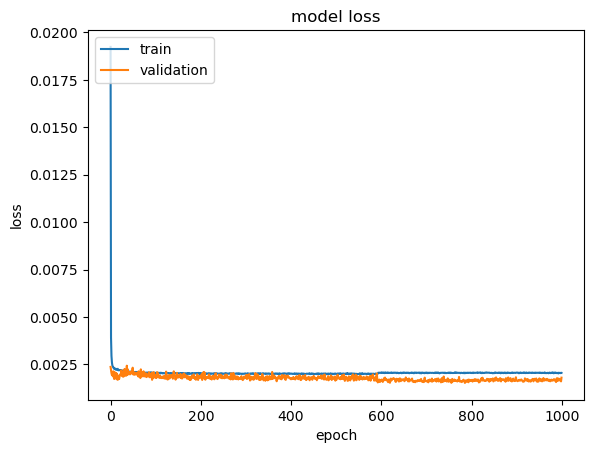

In [67]:
import numpy as np
import matplotlib.pyplot as pt


plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title("model loss")
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Dataset','validation'],loc="upper left")
plt.show()

In [ ]:
plt.subplots(1, figsize=(10,10))     
plt.plot(train_sizes, train_mean, '--', color="#111111",  label="Training score")     
plt.plot(train_sizes, test_mean, color="#111111", label="Cross-validation score")     
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color="#DDDDDD")     
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color="#DDDDDD")     
plt.title("Learning Curve")     plt.xlabel("Training Set Size"), plt.ylabel("Accuracy Score"), plt.legend(loc="best")     
plt.tight_layout()     
plt.show()

In [ ]:
#load model
from keras.models import Sequential, load_model, model_from_json
def load_keras_model(dataset,loss,optimizer):
        json_file = open(dataset+'_best_model'+'.json', 'r')
        loaded_model_json = json_file.read()
        json_file.close()
        model = model_from_json(loaded_model_json)
        model.compile(optimizer=optimizer, loss=loss, metrics = None)
        model.load_weights(dataset+'_best_model'+'.h5')
        return model

In [13]:
import random
import chess
board = chess.Board()
moves = []
model = load_keras_model('chess','mse','Adam')
def calculate_move(depth,board,epochs):
    first_legal_moves = [board.san(i) for i in list(board.legal_moves)]
    #first_legal_moves = str(board.legal_moves)[38:-2].replace(',','').split()
    scores = [[0]] * len(first_legal_moves)
    for epoch in range(epochs):
        for first_move in range(len(first_legal_moves)):
            play_board = board.copy()
            play_board.push_san(first_legal_moves[first_move])
            for _ in range(depth):
                legal_moves = str(play_board.legal_moves)[38:-2].replace(',','').split()
                try:
                    move = random.choice(legal_moves)
                 except:
                    scores[first_move] *= 1000
            matrix = make_matrix(play_board.copy())
            translated = np.array(translate(matrix,chess_dict))
            scores[first_move] += model.predict(translated.reshape(1,8,8,12))*(maximum-minimum)+minimum
        print('Epoch',str(epoch+1)+'/'+str(epochs))
    return first_legal_moves[scores.index(max(scores))]
#move= calculate_move1(10,chess.Board(),100)

In [ ]:
pip install keras

In [ ]:
pip install tensorflow


In [ ]:
pip uninstall eventlet

chess.board("k8/7n/p5pq/8/r2PPQB/B1K2N2")

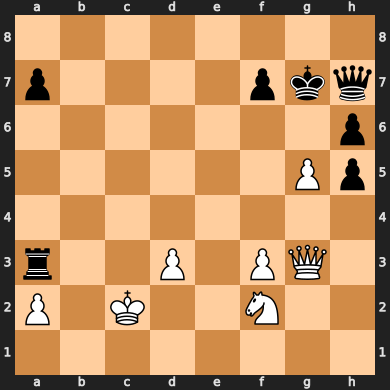

In [46]:
import chess
chess.Board("8/p4pkq/7p/6Pp/8/r2P1PQ1/P1K2N2/8")

In [72]:
hist=[]
b1 = "8/rk6/8/8/8/7P/7K/R7"
b2 = "8/rk6/8/8/8/7P/7K/R7"
b3 = "qk6/7r/r7/8/8/7B/7K/Q7"
b4 = "8/rk6/5qpp/8/5QK1/6RP/8/B7"
b5 ="8/k7/7b/6pp/8/7P/7B/K7"
b = [b1,b2,b3,b4,b5]
#b6= "8/8/8/8/8/8/7Q/5k1K"
for loop in range(100):
    n5 = random.choice(b)
    board = chess.Board(b5)

    choice=5
    base1="Tree"
    base2="Tree"
    white = random.choice([1,0])

    if(choice==3):
        base1 = "Tree"

    elif (choice==5):
        base2="NN"
        #white=0
    elif(choice==4):
        base1="Tree"
        base2 = "Tree"
    moves = 0
    pgn = []
    game = chess.pgn.Game()
    evaluations = []
    sm = 0
    cnt = 0
    curve  = [ [0]*2 for i in range(2)]
    # curve = np.zeros((5,100,1000,2))

    j=0
    while((not board.is_game_over())):
        all_moves = [board.san(i) for i in list(board.legal_moves)]
        start = time.time()
        if(white==1):
            root = node(board)
            root.state = board
            result = mcts_pred(board,root,board.is_game_over(),white,choice,base1,base2)
            
        elif(choice==5 and white==0):
            start = time.time()
            translated = np.array(translate(matrix,chess_dict))
            result = calculate_move(3,board,5)
            
        else:
            root = node(board)
            root.state = board
            result = mcts_pred(board,root,board.is_game_over(),white,choice,base1,base2)
            #print("time taken to iteration",j,(time.time()-start))
        try:
            board.push_san(result)

        except:
            #print(result)
            print("invalid move. game over")
            break
        #print(result)
        score = staticAnalysis(board,white)
        col="BLACK"
        if(white):
            col="WHITE"
        #print("score for ",col,"= ",score)
#As the last score is total score of the game for the player
        curve[white] = (score)
        pgn.append(result)
        white ^= 1
        j+=1

        moves+=1
        #info = engine.analyse(board, chess.engine.Limit(depth=24))
        #evaluat += info['score'].white()
        #print(board)

        #print("-----------move done-----------")

    #print(" ".join(pgn))
    #print()
    #{'string': 'NNUE evaluation using nn-ad9b42354671.nnue enabled', 'depth': 24, 'seldepth': 24, 'multipv': 1, 'score': PovScore(Cp(0), WHITE), 'nodes': 103968, 'nps': 4725818, 'hashfull': 7, 'tbhits': 0, 'time': 0.022, 'pv': [Move.from_uci('h1g2'), Move.from_uci('b4b5'), Move.from_uci('g2g3'), Move.from_uci('b5c5'), Move.from_uci('g3f4'), Move.from_uci('c5b4'), Move.from_uci('f4f5'), Move.from_uci('b4c5')]}

    #print(info)
    #print(evaluations)
    #We are showing score for each player after each move, so in final result the score is only based on the winner.
    #If player 1 wins, it should show 1-0 , if there is a draw it will show 1/2-1/2 and 0-1 otherwise.
    #print(board.result())

    game.headers["Result"] = board.result()
    hist.append(curve)
    #clearing the board
    board=chess.Board("8/8/8/8/8/8/8/8")
    clear_output()
    

In [70]:
hist=[]
curve  = [ [0]*2 for i in range(2)]
hist.append(curve)
print(hist)
print("===",curve)

[[[0, 0], [0, 0]]]
=== [[0, 0], [0, 0]]


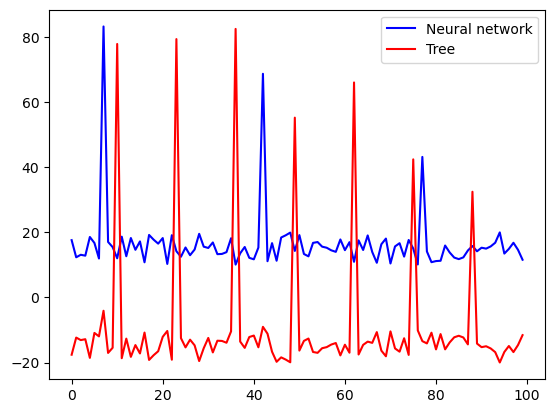

In [75]:
import numpy as np
import matplotlib.pyplot as pt
lst = [[0]*100 for i in range(2)]

for i in range(100):
    lst[i]=hist[i]

# visualize learning curves on train/test data
pt.plot(lst[0], 'b-')
pt.plot(lst[1], 'r-')
#pt.plot([0, len(curve[1])], [baseline_error, baseline_error], 'g-')
pt.plot()
#for full board
pt.legend(["Neural network","Tree"])
pt.show()